# Lab 2.1: Learning compact representations of single-cell data using AEs

## Prerequisities

We'll use a deep learning framework "Tensorflow". Specifically, we'll use version 2.8.0 that can be installed using PyPi (pip) as below:
    
```bash
pip install tensorflow==2.8.0
pip install protobuf==3.20.*
```

The first command install tensorflow and the second command resolves a dependency issue (This tensorflow version has issues with protobuf package >3.20.x
Run the thes commands in a new cell of this notebook or open a terminal and run it there. Thereafter restart the notebook to have the package available.

In [1]:
# import base modules
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [78]:
sns.set(style="ticks", font_scale=1)

Same as before: seaborn (works on top of matplotlib) figure styles: [https://seaborn.pydata.org/tutorial/aesthetics.html#seaborn-figure-styles](https://seaborn.pydata.org/tutorial/aesthetics.html#seaborn-figure-styles)

We'll use the same single-cell data "sun" as we used yesterday. Let's read and preprocess it the same as before. Here we'll only use standard scaling (z-scores)

## Read in data

In [2]:
# Sun

df = pd.read_parquet(os.path.join("../data", "sun_counts.pqt"))
df_meta = pd.read_csv(os.path.join("../data", "sun_meta.csv"), index_col=0)

we don't need metadata here to learn but we'll use cell type labels for visualiazations after building and training our autoencoder.

In [3]:
print(f"count data size: {df.shape}")
print(f"metadata size: {df_meta.shape}")

count data size: (8829, 10851)
metadata size: (8829, 14)


Same as we saw yesterday, the data is from biological cells. Below is a protocol, same as we saw yesterday, on how this data is generated for a specific technology (10x Chromium)

![Single cell RNA sequencing](images/10xschematic.jpg "protocol")

In [4]:
# prepare X and y

X = df.copy() # changes made in X won't affect df. For dictionaries, use deepcopy()
y = df_meta["cell_type"]

In [5]:
# domain specific (Make sure each cell has same total RNA)
X = X.div(X.sum(1), 0)  # Divide each value in a row by the row sum
X = X*1e6 
X = np.log2(X+1)

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
# We'll do a 80-20 split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

Here we'll learn train data to learn autoencoder embeddings, and we'll use test data to check the model error. We'll visualize the embeddings (codes) of all data together in the end.

Since Autoencoder is unsupervised, principles of train and test data are more relaxed. Technically, we do not need a test set, but it is good to check performance on a held-out dataset, i.e. The performance of how accurate the model is representing.

## Preprocessing and QC

Before we proceed with building a classifiers, there are some things to keep in mind:
    
1. There may be poor quality samples that we want to avoid learning from,
2. There may be some features that might be redundant, and 
3. In cases like the one in hand, we have more features than samples (10,851 vs 7,063). Such high dimensional data may be difficult for learners. This refers to "curse of dimensionality", especially when the data can not be represented appropriates in 3D physical spaces. For gene expression data, this is the case, however due to biology, several genes are cell type-specific i.e. they are expressed higher in specific cell types. **Domain knowledge helps**!

### Removing atypical samples

First we will compute total genes expressed per sample

In [8]:
def count_genes(df):
    df_bool = df.astype(bool)
    exp_genes = df_bool.sum(axis=1)
    return exp_genes

def count_total_count(df):
    sums = df.sum(1)
    return sums

In [9]:
gene_counts, total_counts = count_genes(train_X), count_total_count(train_X)

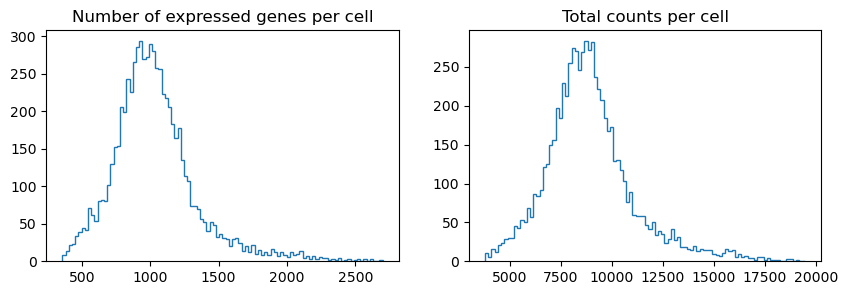

In [10]:
# We can plot these to see if there are some outliers

plt.figure(figsize=(10,3))
ax = plt.subplot(1,2,1)
ax.hist(gene_counts, histtype="step", bins=100)
ax.set_title("Number of expressed genes per cell")

# We can plot these to see if there are some outliers
ax = plt.subplot(1,2,2)
plt.hist(total_counts, histtype="step", bins=100)
plt.title("Total counts per cell")
plt.show()

<ins>Note</ins>: The choice of how to select outliers is mostly domain specific. In clinical data, it maybe "exceptionally atypical measurements", in financial data, it may be a specific month (April saw a reducing in US financial debt, so can't rely observations during that time, unless of course if that is your target. In cases, where such information is not possible, dedicated outlier detection methods can be utilized. [https://scikit-learn.org/stable/modules/outlier_detection.html](https://scikit-learn.org/stable/modules/outlier_detection.html)

From our training data, we will keep cells with total expressed genes between 500 and 2000 and remove total genes per cell over 7500.

In [11]:
gene_min, gene_max = 500, 2000
count_max = 7500

In [12]:
idxs_rm = []
idxs_rm = gene_counts[(gene_counts<gene_min)&(gene_counts>gene_max)].index.tolist()
idxs_rm = idxs_rm + total_counts[total_counts>count_max].index.tolist()

In [13]:
print(len(idxs_rm))

5437


In [14]:
train_X, train_y = train_X.drop(idxs_rm), train_y.drop(idxs_rm)

## Normalization

We'll do standard scaling here.

In [15]:
# Here we'll generate three scalings and store data 

from sklearn.preprocessing import MinMaxScaler
minmaxscaler = MinMaxScaler()
minmaxscaler.fit(train_X)

train_X_minmax = minmaxscaler.transform(train_X)
train_X_minmax = pd.DataFrame(train_X_minmax, columns=train_X.columns, index=train_X.index)

test_X_minmax = minmaxscaler.transform(test_X) 

This normalizes counts such that each cell's total count sums to 1 million and take log2 of it. Computing log2 makes really high gene expressions to be comparable to others. It's a lightweight way of mitigating gene expression disparity. \
Further, it "approximates" a normal distribution (a nice property of have). \
In single-cell RNA data, "approximates" doesn't usually occur due to high sparsity i.e. many features are 0's (check with (train_X==0).sum()). This is not a settled issue. Several different approaches are possible and the science is not settled. Some normalizations are discussed in this review: [https://link.springer.com/article/10.1186/s12864-024-10364-5](https://link.springer.com/article/10.1186/s12864-024-10364-5)

In [16]:
import tensorflow as tf

2024-05-28 12:52:09.386086: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-05-28 12:52:09.386116: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


We'll build autoencoder, that is composed of following subnetworks:

| Component | Layer dimension | 
| --- | --- | 
| Encoder | [256, 128] | 
| Decoder | [128, 256] | 

Bottleneck (code) size: 64 \
Learning rate: 1e-4 (0.0001) \
batch_size: 128 \
Optimizer: Adam (https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) 

# Build model

In [17]:
from tensorflow.keras.models import Model # Combines layers into a single model, https://www.tensorflow.org/api_docs/python/tf/keras/Model
from tensorflow.keras.layers import Input, Dense # Dense layer is a fully connected layer, Input layer forms a desired shaped input, 
# https://www.tensorflow.org/api_docs/python/tf/keras/layers

In [28]:
activation_func = "linear"
out_activation_func = "sigmoid"

In [29]:
# definte input dimension
input_shape = train_X_minmax.shape[1]

# Input layer
input_layer = Input(shape=(input_shape,))

# Encoder
encoded = Dense(256, activation=activation_func)(input_layer)
encoded = Dense(128, activation=activation_func)(encoded)

# Bottleneck
bottleneck = Dense(32, activation='linear')(encoded)

# Decoder
decoded = Dense(128, activation=activation_func)(bottleneck)
decoded = Dense(256, activation=activation_func)(decoded)

# Output layer
output_layer = Dense(input_shape, activation=out_activation_func)(decoded)

In [30]:
# Put everything in a model. It under the hood, creates a graph from input to output with all intermediate components
autoencoder = Model(inputs=input_layer, outputs=output_layer)


# Show network

In [31]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10851)]           0         
                                                                 
 dense_6 (Dense)             (None, 256)               2778112   
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dense_8 (Dense)             (None, 32)                4128      
                                                                 
 dense_9 (Dense)             (None, 128)               4224      
                                                                 
 dense_10 (Dense)            (None, 256)               33024     
                                                                 
 dense_11 (Dense)            (None, 10851)             2788

## Training

In [55]:
## configure the network
learning_rate = 1e-5
loss_function = "mean_squared_error"

Choice of loss function depends on the task. For regression mean squared error, root mean squared error etc. are the general choice. Loss functions available as part of tensorflow are here: https://www.tensorflow.org/api_docs/python/tf/keras/losses

You can also write your own loss function if you are more familiar with tensorflow and deep learning.

In [56]:
## Compile the model (It puts the graph ready to compute - i.e. configure the model and optimizer

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
autoencoder.compile(optimizer=optimizer, loss=loss_function)

if we want to use default settings, the above command can be written as:
```python
autoencoder.compile(optimizer="SGD",  loss='mean_squared_error')
```

In [57]:
# Training hyperparameters
batch_size=128
epochs = 50 # Number of times entire data passes (both forward and backward) the network
validation_split_size = 0.2 # creates a validation set of this much data from train_X to evaluate on

In [58]:
# Train the autoencoder
autoencoder.fit(train_X_minmax, train_X_minmax, epochs=epochs, batch_size=batch_size, shuffle=True, validation_split=validation_split_size, verbose=2)

Epoch 1/50
11/11 - 1s - loss: 0.0303 - val_loss: 0.0310 - 572ms/epoch - 52ms/step
Epoch 2/50
11/11 - 0s - loss: 0.0303 - val_loss: 0.0310 - 189ms/epoch - 17ms/step
Epoch 3/50
11/11 - 0s - loss: 0.0302 - val_loss: 0.0309 - 179ms/epoch - 16ms/step
Epoch 4/50
11/11 - 0s - loss: 0.0302 - val_loss: 0.0309 - 169ms/epoch - 15ms/step
Epoch 5/50
11/11 - 0s - loss: 0.0301 - val_loss: 0.0309 - 186ms/epoch - 17ms/step
Epoch 6/50
11/11 - 0s - loss: 0.0301 - val_loss: 0.0309 - 175ms/epoch - 16ms/step
Epoch 7/50
11/11 - 0s - loss: 0.0301 - val_loss: 0.0308 - 170ms/epoch - 15ms/step
Epoch 8/50
11/11 - 0s - loss: 0.0301 - val_loss: 0.0308 - 176ms/epoch - 16ms/step
Epoch 9/50
11/11 - 0s - loss: 0.0301 - val_loss: 0.0308 - 169ms/epoch - 15ms/step
Epoch 10/50
11/11 - 0s - loss: 0.0301 - val_loss: 0.0308 - 196ms/epoch - 18ms/step
Epoch 11/50
11/11 - 0s - loss: 0.0300 - val_loss: 0.0308 - 196ms/epoch - 18ms/step
Epoch 12/50
11/11 - 0s - loss: 0.0300 - val_loss: 0.0308 - 188ms/epoch - 17ms/step
Epoch 13/50
1

Shuffle shuffles samples in the input before each epoch.

## save the model

In [61]:
models_dir = "models"

if not os.path.exists(models_dir):
    os.mkdir(models_dir)

In [63]:
autoencoder.save(os.path.join(models_dir, "autoencoder_minmax_default.h5"))

In [65]:
## Model can be loaded with load_model function from tf models
from tensorflow.keras.models import load_model

autoencoder = load_model(os.path.join(models_dir, "autoencoder_minmax_default.h5"))


We'll need the access to encoder outputs to get the bottleneck. However, our model (autoencoder)'s predict will give the output of last layer. But we can re-use the layers from autoencoder to build another model. The layer weights are automatically shared.




In [73]:
encoder = Model(inputs=input_layer, outputs=bottleneck) # seperate encoder
encoded_input = Input(shape=(32,))
decoder_layer1 = autoencoder.layers[-3](encoded_input)
decoder_layer2 = autoencoder.layers[-2](decoder_layer1)
decoder_output = autoencoder.layers[-1](decoder_layer2)
decoder = Model(inputs=encoded_input, outputs=decoder_output) # seperate decoder

## Get bottleneck representation (code)

In [98]:
reps = encoder.predict(train_X_minmax)
print(reps.shape)

(1626, 32)


In [99]:
## compute PCA with 2 components
from sklearn.decomposition import PCA

pca = PCA(2)
transformed = pca.fit_transform(reps)

In [100]:
train_y

index
GACGCGTAGTTATCGC-1-Sun_sample4_TC                  B
GGCTGGTGTTGTACAC-1-Sun_sample4_TC       CD4+ T cells
TTCGAAGAGTACTTGC-1-Sun_sample4_TC       CD8+ T cells
TCTCTAAGTCTAGTGT-1-Sun_sample4_TC       CD4+ T cells
CAACCTCAGTCGATAA-1-Sun_sample4_TC       CD4+ T cells
                                          ...       
TCAGCTCTCTGCCCTA-1-Sun_sample4_TC                  B
TGGCGCAGTGACTCAT-1-Sun_sample4_TC       CD4+ T cells
ATTGGTGAGTTCGATC-1-Sun_sample4_TC       CD4+ T cells
TACGGGCGTTCGCTAA-1-Sun_sample4_TC    CD14+ Monocytes
GTCAAGTTCCTTGCCA-1-Sun_sample3_TB       CD8+ T cells
Name: cell_type, Length: 1626, dtype: object

In [101]:
pca_df = pd.DataFrame(transformed, index=train_X.index, columns=["PC1", "PC2"])
pca_df["cell_type"] = train_y.to_numpy()

In [102]:
pca_df.head()

,PC1,PC2,cell_type
index,,,
GACGCGTAGTTATCGC-1-Sun_sample4_TC,1.299346,0.820091,B
GGCTGGTGTTGTACAC-1-Sun_sample4_TC,-4.889173,-2.020645,CD4+ T cells
TTCGAAGAGTACTTGC-1-Sun_sample4_TC,-3.407486,-1.745196,CD8+ T cells
TCTCTAAGTCTAGTGT-1-Sun_sample4_TC,-2.090809,-1.676975,CD4+ T cells
CAACCTCAGTCGATAA-1-Sun_sample4_TC,-1.880180,-1.174754,CD4+ T cells


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

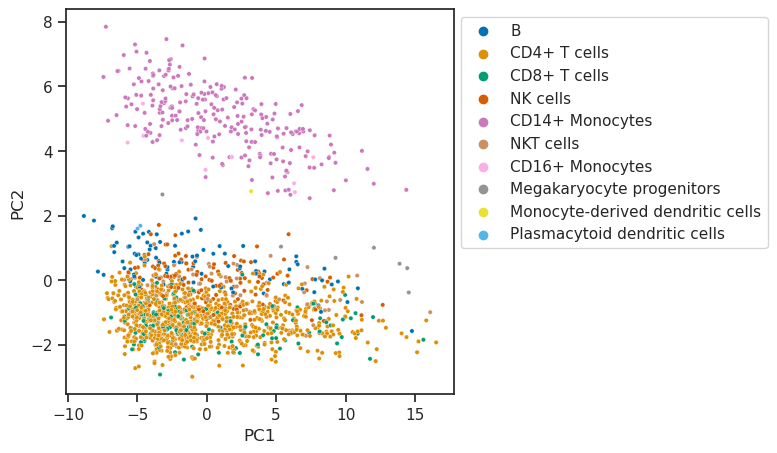

In [103]:
plt.figure(figsize=(5,5))
scatter = sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cell_type', palette='colorblind', s=10, legend='full')
# move legend outside the plot so that it doesn't overlay on the data points
plt.legend(bbox_to_anchor=(1,1))

As you can see, there seems to be some seperation of classes in the bottleneck layer.

## Tasks

1. Get the bottleneck codes for the test set and compute the PCA
2. Compute the mean squared error for the test set reconstruction (<ins>Hint</ins>: Representations are the decoder outputs.)
3. Find features where the mean squared error is the highest for the test set reconstruction